In [38]:
from glob import glob

from matplotlib import image
from sklearn.utils import resample

from torch.utils.data import Dataset

import numpy as np
import os
import os.path as op
import glob
import sys
import logging
import SimpleITK as sitk
from tqdm import trange, tqdm
from tqdm.contrib.concurrent import thread_map
from multiprocessing import cpu_count
import torchio as tio
import h5py as h5
import matplotlib.pyplot as plt

In [39]:
data_dir = '/media/hdd/HCP_1200'
list_labels = glob.glob(op.join(data_dir, '*'))
list_labels.sort()
list_basenames = [op.basename(x) for x in list_labels]
list_images_t1 = [op.join(x,'unprocessed','3T','T1w_MPR1',op.basename(x)+'_3T_T1w_MPR1.nii.gz') for x in list_labels]
list_images_t2 = [op.join(x,'unprocessed','3T','T2w_SPC1',op.basename(x)+'_3T_T2w_SPC1.nii.gz') for x in list_labels]

In [40]:
list_images_t1[0]

'/media/hdd/HCP_1200/100206/unprocessed/3T/T1w_MPR1/100206_3T_T1w_MPR1.nii.gz'

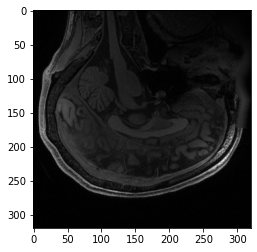

In [41]:
img = sitk.ReadImage(list_images_t1[2])
img_arr = sitk.GetArrayFromImage(img)
plt.imshow(img_arr[...,img_arr.shape[2]//2], cmap='gray')

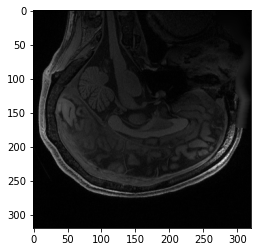

In [42]:
#normalize img_arr
img_arr = (img_arr - img_arr.mean()) / img_arr.std()
img_arr = img_arr.astype(np.half)
plt.imshow(img_arr[...,img_arr.shape[2]//2], cmap='gray')
# sitk.WriteImage(sitk.GetImageFromArray(img_arr), 'test.nii.gz') 


In [43]:
spacing = [1.0,1.0,1.0]
spacing = np.array(spacing)
spacing *= 8
target_shape = (108, 145, 145)
factor = spacing[2] / spacing[0]
aniso_transform = tio.RandomAnisotropy(axes=2, downsampling=10)
resize_transform = tio.Resize(target_shape=target_shape)
resample_transform = tio.Resample(target=spacing)
blur_transform = tio.RandomBlur(6)
transform  = tio.Compose([resample_transform,resize_transform,blur_transform])
# transform = tio.Compose([blur_transform,aniso_transform,resize_transform])
transform_gt = resize_transform

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/torchio/transforms/preprocessing/spatial/resize.py:70: UserWarning: Output shape (108, 146, 145) != target shape (108, 145, 145). Fixing with CropOrPad
  warnings.warn(message)


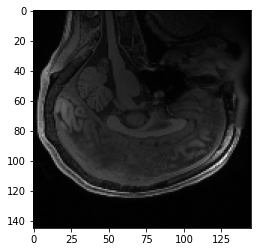

In [44]:
img_gt = img
img_gt = transform_gt(img_gt)
img_gt = sitk.GetArrayFromImage(img_gt)
plt.imshow(img_gt[...,img_gt.shape[2]//2], cmap='gray')



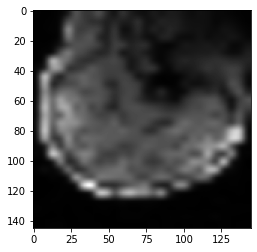

In [51]:
img_transformed = transform(img)
img_transformed_arr = sitk.GetArrayFromImage(img_transformed)
plt.imshow(img_transformed_arr[...,img_transformed_arr.shape[2]//2], cmap='gray')

In [46]:
# import sys
# sys.getsizeof(img_arr)

In [49]:
augmentation_transform = []
augmentation_transform.append(tio.RandomFlip(axes=(0,1)))
augmentation_transform.append(tio.RandomAffine())
augmentation_transform.append(tio.RandomElasticDeformation())
augmentation_transform.append(tio.RandomMotion())
augmentation_transform.append(tio.RandomBiasField())
augmentation_transform.append(tio.RandomSwap())
augmentation_transform.append(resample_transform)
augmentation_transform.append(resize_transform)
augmentation_transform.append(blur_transform)
augmentation_transform = tio.Compose(augmentation_transform)



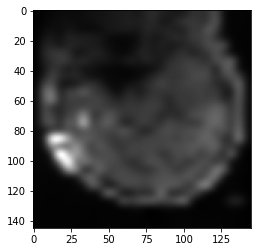

In [50]:
img_aug = augmentation_transform(img)
img_aug_arr = sitk.GetArrayFromImage(img_aug)
plt.imshow(img_aug_arr[...,img_aug_arr.shape[2]//2], cmap='gray')


In [63]:
augmentation_transform.keep = {'t1':'gt_t1'}
subject = tio.Subject(
    t1=tio.ScalarImage(list_images_t1[0]),
    t2=tio.ScalarImage(list_images_t1[0]),
)

In [64]:
subject = augmentation_transform(subject)

In [74]:
t1_arr = subject.t1.data.numpy()[0]
t2_arr = subject.t2.data.numpy()[0]
t1_gt_arr = subject.gt_t1.data.numpy()[0]



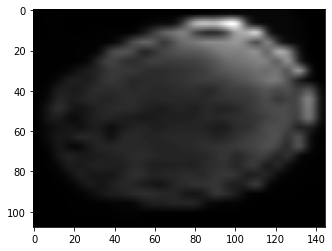

In [72]:
plt.imshow(t1_arr[...,t1_arr.shape[2]//2], cmap='gray')

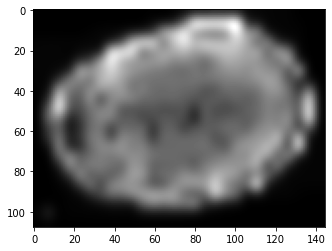

In [73]:
plt.imshow(t2_arr[...,t2_arr.shape[2]//2], cmap='gray')

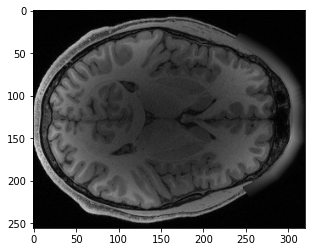

In [75]:
plt.imshow(t1_gt_arr[...,t1_gt_arr.shape[2]//2], cmap='gray')

In [76]:
subject['t1']

ScalarImage(shape: (1, 108, 145, 145); spacing: (1.70, 1.54, 1.54); orientation: LAS+; dtype: torch.FloatTensor; memory: 8.7 MiB)

In [77]:
batch = []
batch.append(subject['t1'].data.numpy())

In [79]:
np.array(subject['t1'].data.numpy()).shape

(1, 108, 145, 145)